## Clasificando señales de radio desde el espacio con Keras

<p><img alt="COVID" width=700 src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/7e/Allen_Telescope_Array_-_Flickr_-_brewbooks_%288%29.jpg/1199px-Allen_Telescope_Array_-_Flickr_-_brewbooks_%288%29.jpg", align="center", hspace=0, vspace=5></p>

En este notebook buscaremos realizar una clasificación de señales de radio obtenidas desde el espacio, las cuales queremos clasificar en 4 categorías (Squiggle, Narrowband, Narrowbaddrd y Noise). Nos daremos cuenta que un problema de este tipo (Análisis de señales) se puede tratar como un problema de clasificación de images utilizando una CNN.

El notebook es parte de un proyecto dirigido en la plataforma coursera, el cual pueden encontrar haciendo click <a href='https://www.coursera.org/projects/classify-radio-signals-space-keras-cnn'>aquí</a>.

<h3>Contenido</h3>
<div class="alert alert-danger" role="alert">
<ol>
    <li><a href="#section1"> Importación de librerías</a></li>
    <li><a href="#section2"> Cargando y Preprocesando la data de tipo SETI </a></li>
    <li><a href="#section3"> Graficando el espectograma 2D </a></li>
    <li><a href="#section4"> Generando más datos </a></li>
    <li><a href="#section5"> Construyendo nuestra CNN </a></li>
    <li><a href="#section6"> Definiendo el decaimiento tasa de aprendizaje y compilando el modelo </a></li>
    <li><a href="#section7"> Entrenando el modelo </a></li>
    <li><a href="#section8"> Evaluando el modelo </a></li>
</ol>
</div>

<a id="section1"></a>
## 1. Importación de Librerías
<hr>
Primero importamos las librerías que utilizaremos para la clasificación; entre ellas numpy y pandas para preprocesamiento, livelossplot para llamar el callback Plot Losses, tensorflow para construir nuestra CNN, y scikitlearn para las métricas de evaluación.

In [48]:
#Importamos nuestras librerías.

from livelossplot.tf_keras import PlotLossesCallback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
from io import StringIO

import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn import metrics

np.random.seed(42)
import warnings;warnings.simplefilter('ignore')
%matplotlib inline
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.1.0


<a id="section2"></a>
## 2. Cargando y Preprocesando la data de tipo SETI
<hr>
SETI es el acrónimo del inglés search for extra terrestrial intelligence (búsqueda de inteligencia extraterrestre). Existen numerosos proyectos SETI, que tratan de encontrar vida extraterrestre inteligente, ya sea por medio del análisis de señales electromagnéticas capturadas en distintos radiotelescopios, o bien enviando mensajes de distintas naturalezas al espacio con la esperanza de que alguno de ellos sea contestado.

Para nuestro análisis disponemos tanto de un conjunto de entrenamiento, como de un conjunto de validación, en donde ambos se componen de dos archivos .csv cada uno, los cuales son el archivo **images.csv** y el archivo **labels.csv**. 

El archivo **images.csv** contiene imagenes del espectograma en 2D obtenido por el Allen Telescope Array, convertidas en vectores donde los valores son la intensidad de pixel y además ya normalizadas. El archivo **labels.csv** contiene las etiquetas de clase, las cuales son 4 en total y han sido codificadas como vectores con OneHotEncoder.

In [49]:
# Importamos tanto el conjunto train como el conjunto validation

# El código es un poco engorroso porque estamos trayendo los datos de google drive.

orig_url='https://drive.google.com/file/d/1RTg586udp-99UGcg6C4y3iJWT3Lmgs-W/view?usp=sharing'
file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
train_images = pd.read_csv(csv_raw, header = None)




orig_url='https://drive.google.com/file/d/1DVf_vbN75Pgg_pLAIki4zMO51-BzTFR8/view?usp=sharing'
file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
val_images = pd.read_csv(csv_raw, header = None)



orig_url='https://drive.google.com/file/d/1Cubh8TMrjc7idG9JKDOEyUfG_vLwlk5J/view?usp=sharing'
file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
train_labels = pd.read_csv(csv_raw, header = None)




orig_url='https://drive.google.com/file/d/1x02iJEQESuQeKz9dKDVsArl7X4nmEIzr/view?usp=sharing'
file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
val_labels = pd.read_csv(csv_raw, header = None)

Si analizamos el conjunto de imagenes, nos damos cuenta que son vectores que contienen las intesidades de cada pixel ya normalizadas.

In [7]:
# Analizamos el conjunto images

train_images.head(5)

,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,...,0.639216,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,...,0.639216,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412


Ahora si analizamos el conjunto de labels, podemos darnos cuenta que son vectores codificados con OneHotEncoder y corresponden a 4 tipos de señales diferentes: La primera corresponde a señales de tipo Squiggle, la segunda es una señal NarrowBand, la tercera señal es Noise, y la cuarta categoría corresponde a señales NarrowBanddrd.

In [8]:
# Analizamos el conjunto labels

train_labels.head(5)

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


Analizemos ahora los tamaños de estas matrices, para que nos sea facil más adelantes fijar los parámetros de nuestra red neuronal.

In [13]:
# Vemos ahora los shapes de cada conjunto

print("Training image set shape: ", train_images.shape)
print("Training labels set shape: ", train_labels.shape)
print(" ")
print("Validation image set shape: ", val_images.shape)
print("Validation labels set shape: ", val_labels.shape)

Training image set shape:  (3200, 8192)
Training labels set shape:  (3200, 4)
 
Validation image set shape:  (800, 8192)
Validation labels set shape:  (800, 4)


Podemos ver que tenemos una entrada de 8192 carácteristicas en un conjunto de entrenamiento de 3200 muestras, y un conjunto de validación de 800 muestras. Además, como ya sabíamos, existen 4 salidas que son los tipos de señal.

Ahora realizaremos un reshape a nuestro conjunto, para trabajarlo de manera matricial y poder plotearlo.

In [17]:
# Redefinimos los shapes de cada conjunto

x_train = train_images.values.reshape(3200, 64, 128, 1)
x_val = val_images.values.reshape(800, 64, 128, 1)

y_train = train_labels.values
y_val = val_labels.values

<a id="section3"></a>
## 3. Graficando el espectograma 2D
<hr>
En esta sección de la libreta graficaremos el espectograma obtenido por estas señales para entender un poco con que tipo de datos estamos trabajando; para esto haremos un subplot y veremos al azar 6 señales entre las que tenemos en nuestro conjunto de entrenamiento. Utilizaremos np.squeze() para eliminar el eje adicional que corresponde al canal de la señal.

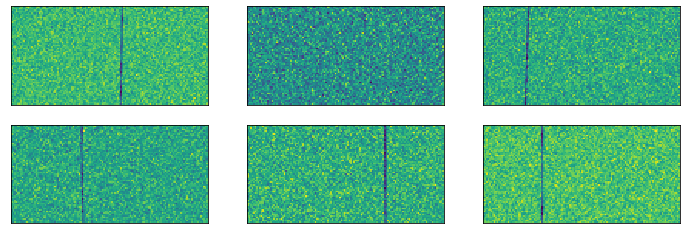

In [31]:
# Creamos la figura con matplotlib

plt.figure(0,figsize = (12,4))
for i in range(1,7):
    plt.subplot(2,3,i)
    img = np.squeeze(x_train[np.random.randint(0,x_train.shape[0])])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

Cada imagen corresponde a una señal al azar de nuestro conjunto de entrenamiento, aunque pareciera ser que en cada una podemos extraer información del color. Esto no es relevante realmente, por lo que ahora la veremos con un colormap en escala de grises.

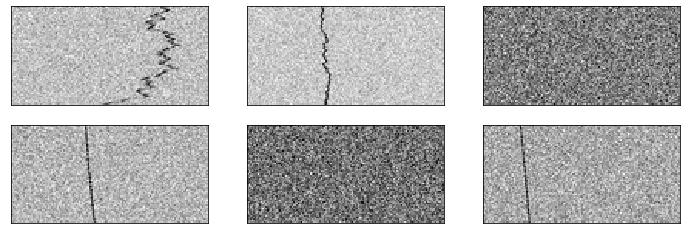

In [32]:
# Creamos la figura con matplotlib pero ahora con escala de grises

plt.figure(0,figsize = (12,4))
for i in range(1,7):
    plt.subplot(2,3,i)
    img = np.squeeze(x_train[np.random.randint(0,x_train.shape[0])])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')

<a id="section4"></a>
## 4. Generando más datos
<hr>
Ahora utilizaremos real-time data augmentation para generar batches de imagenes con formato tensor, para esto importamos la librería ImageDataGenerator y creamos nuestro aumento para nuestro train set como para nuestro validation set. Si bien podemos utilizar multiples técnicas para el augmentation, utilizaremos simplemente un volteo horizontal por simplicidad.

In [35]:
# Importamos desde Keras nuestro aumentador de datos

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(horizontal_flip = True)
datagen_train.fit(x_train)

datagen_val = ImageDataGenerator(horizontal_flip = True)
datagen_val.fit(x_val)

Podríamos utilizar muchos otros hiperparámetros para alterar nuestra función ImageDataGenerator, a continuación se puede observar una lista de ellos

In [34]:
# Ejecutar este código para analizar la función ImageDataGenerator

ImageDataGenerator?

Cabe destacar que como nuestros datos ya estaban normalizados, no es necesario realizar una normalización para estas nuevas imagenes creadas. Con esto estamos listos para crear nuestra CNN.

<a id="section5"></a>
## 5. Construyendo nuestra CNN
<hr>
Ahora viene la parte más complicada que consiste en construir nuestra CNN, pero antes destacar que utilizaremos una CNN ya que estas son capaces de romper los patrones complejos que hay en imágenes

In [36]:
# Importamos las librerías que necesitaremos para la CNN

from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

Con nuestras librerías ya importadas procedemos a construir nuestra CNN, la cual tendrá un aarquitectura secuencial y estará compuesto de 2 capas convolucionales la primera con 32 feature maps y la segunda con 64. Cada capa tendra un kernel_size de 5x5, y además se le aplicará un BatchNormalization para así normalizar cada capa.

La función de activación sera relu, y luego agregaremos al modelo un MaxPooling, que simplemente es un downsamplig no lineal. Cerraremos con un Dropout para regularizar.

Luego de recorrer ambas capas, se realizará un flattening para poder conectar toda la red, que tendra una capa Dense para cerrar de 1024 neuronas, a la cual le realizaremos los mismos ajustes que a las dos capas convolucionales.

In [40]:
# Arquitectura de la red neuronal

# Inicializando el modelo secuencial
model = Sequential()

# 1st Convolution layer
model.add(Conv2D(32, (5,5), padding = 'same', input_shape = (64, 128, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(64, (5,5), padding = 'same', input_shape = (64, 128, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(4,activation='softmax'))

Antes de comenzar a entrenar el modelo, vamos a ver algo importante que es el cómo establecer un valor óptimo para la tasa de aprendizaje.

<a id="section6"></a>
## 6. Definiendo el decaimiento tasa de aprendizaje y compilando el modelo
<hr>
Utilizaremos decaimiento exponencial para la tasa de aprendizaje y así no escaparnos del optimo cuando la CNN esta calculando los gradientes, lo cual realizaremos con ADAM.

In [41]:
# Fijamos el decaimiento exponencial y el optimizador ADAM para el cálculo de los gradientes

initial_lr = 0.005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = initial_lr,
    decay_steps = 5,
    decay_rate = 0.96,
    staircase = True
)
optimizer = Adam(learning_rate = lr_schedule)

Como ya tenemos fijados todos nuestros parametros, nos queda compilar nuestro modelo. Cabe destacar que no nos cercioramos de analizar los hiperparámetros, puesto que nuestro objetivo no es obtener el mejor modelo, sino más bien tomar un problema de analisis de señales y transformarlo en un problema de clasificación de imágenes para resolverlo con Keras.

In [45]:
# Compilamos el modelo

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 128, 32)       832       
_________________________________________________________________
batch_normalization_7 (Batch (None, 64, 128, 32)       128       
_________________________________________________________________
activation_7 (Activation)    (None, 64, 128, 32)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 64, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 64, 64)        51264     
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 64, 64)       

Al tener establecido y compilado nuestro modelo, procederemos a el entrenamiento y la evaluación para así finalizar el análisis.

<a id="section7"></a>
## 7. Entrenando el Modelo

Antes de empezar a entrenar el modelo, definiremos un par de callbacks por si necesitamos guardarlo en ciertos checkpoints. La metrica que estaremos monitareando es validation loss buscando minimizarla; y solo guardaremos los pesos, no asi la arquitectura de la CNN.

Utilizaremos un batch_size de tamaño 32, y procederemos a fitear el modelo considerando 12 épocas.

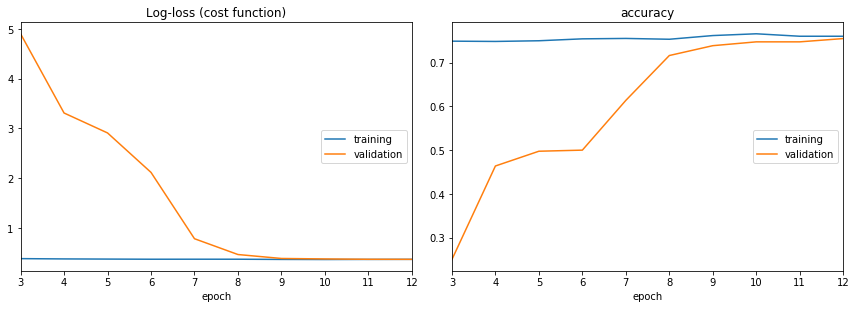

Log-loss (cost function):
training   (min:    0.363, max:    0.637, cur:    0.366)
validation (min:    0.366, max:    4.903, cur:    0.366)

accuracy:
training   (min:    0.680, max:    0.766, cur:    0.760)
validation (min:    0.250, max:    0.755, cur:    0.755)
100/100 [==============================] - 89s 888ms/step - loss: 0.3658 - accuracy: 0.7603 - val_loss: 0.3661 - val_accuracy: 0.7550


In [46]:
checkpoint = ModelCheckpoint('model_weight.h5', monitor = 'val_loss',
                             save_weights_only = True, mode = 'min', verbose = 0)

callbacks = [PlotLossesCallback(), checkpoint]

batch_size = 32

history = model.fit(
        datagen_train.flow(x_train, y_train, batch_size = batch_size, shuffle = True),
        steps_per_epoch = len(x_train) // batch_size,
        validation_data = datagen_val.flow(x_val, y_val, batch_size = batch_size, shuffle = True),
        validation_steps = len(x_val) // batch_size,
        epochs = 12,
        callbacks = callbacks
)

Al finalizar el entrenamiento, nos damos cuenta que la accuracy del modelo es del $0.755$ y la perdida en validación es de $0.366$. Si bien a priori no es un buen modelo, la idea no era ajustarlo de la mejor manera posible, sino mas bien la intuición de como abarcar un problema de analisis de señales como clasificación de imágenes.

<a id="section8"></a>
## 8. Evaluando el Modelo
<hr>
Ahora para finalizar evaluamos el modelo; la forma mas sencilla de hacerlo es con model.evaluate(x_val,y_val), aunque el resultado no será muy diferente a lo obtenido en las iteraciones anteriores.

In [52]:
model.evaluate(x_val,y_val)

800/800 [==============================] - 3s 4ms/sample - loss: 0.3671 - accuracy: 0.7500


[0.36708909580476756, 0.75]

No nos fiaremos simplemente de lo que nos dice el accuracy, sino que analizaremos también la matriz de confusión para ver un detalle más general de los resultados de nuestro modelo.

In [56]:
# Observamos la matriz de confusión

from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

y_true = np.argmax(y_val,1)
y_pred = np.argmax(model.predict(x_val),1)

print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       200
           1       0.50      0.71      0.59       200
           2       0.51      0.30      0.38       200
           3       1.00      1.00      1.00       200

    accuracy                           0.75       800
   macro avg       0.75      0.75      0.74       800
weighted avg       0.75      0.75      0.74       800



Lo valioso de haber hecho esto es que podemos observar que el $F_1$ Score entrega un muy buen resultado en la primera y la cuarta categoría, no obstante las dos del medio son las se aprecian con problemas, las cuales corresponden a Narrowband y Noise respectivamente, asi que podemos aplicar técnicas para reducir el bias enfocandonos en estos conjuntos.

In [57]:
labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]